In [3]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import brier_score_loss, log_loss

In [9]:
backtest_odds = pd.read_csv("../../data/backtesting/backtest_odds.csv")
backtest_odds = backtest_odds.drop(columns=["event_id", "sportsbook"])
backtest_odds["red_odds"] = backtest_odds["red_odds"].apply(lambda x: 100 / (100 + x) if x > 0 else -x / (100 - x))
backtest_odds["blue_odds"] = backtest_odds["blue_odds"].apply(lambda x: 100 / (100 + x) if x > 0 else -x / (100 - x))
backtest_odds["Bovada Sportsbook"] = backtest_odds["red_odds"] / (backtest_odds["red_odds"] + backtest_odds["blue_odds"])
backtest_odds = backtest_odds.drop(columns=["red_odds", "blue_odds"])
backtest_odds

,bout_id,date,red_win,Bovada Sportsbook
0,c1356395d6b055d7,2017-01-15,0.0,0.489879
1,ae803440d778a12b,2017-01-15,0.0,0.328185
2,3f7684492c9df05e,2017-01-15,1.0,0.585987
3,53c3565ee1d3411a,2017-01-15,0.0,0.390764
4,8156479490877d08,2017-01-15,1.0,0.601770
...,...,...,...,...
3955,5238f6470d0557fb,2024-12-14,0.0,0.305344
3956,7b1bc4ff776f12c1,2024-12-14,0.0,0.735516
3957,1a635a5e4551e7d5,2024-12-14,1.0,0.772329
3958,7521015554088962,2024-12-14,1.0,0.351079


In [12]:
backtest_odds = pd.read_csv("../../data/backtesting/backtest_odds.csv")
backtest_odds = backtest_odds.drop(columns=["event_id", "sportsbook"])
backtest_odds["red_odds"] = backtest_odds["red_odds"].apply(lambda x: 100 / (100 + x) if x > 0 else -x / (100 - x))
backtest_odds["blue_odds"] = backtest_odds["blue_odds"].apply(lambda x: 100 / (100 + x) if x > 0 else -x / (100 - x))
backtest_odds["Bovada Sportsbook"] = backtest_odds["red_odds"] / (backtest_odds["red_odds"] + backtest_odds["blue_odds"])
backtest_odds = backtest_odds.drop(columns=["red_odds", "blue_odds"])

model_names = {
    "lr": "Logistic Regression",
    "lr_no_odds": "Logistic Regression (No Odds)",
    "va_lr": "Venn-Abers Logistic Regression",
    "va_lr_no_odds": "Venn-Abers Logistic Regression (No Odds)",
    "lightgbm": "LightGBM",
    "lightgbm_no_odds": "LightGBM (No Odds)",
    "va_lightgbm": "Venn-Abers LightGBM",
    "va_lightgbm_no_odds": "Venn-Abers LightGBM (No Odds)",
}
for model, name in model_names.items():
    preds = pd.read_csv(f"../../model_files/{model}/predictions.csv")
    assert (preds["bout_id"] == backtest_odds["bout_id"]).all()

    backtest_odds[name] = preds["y_pred"]

subset = backtest_odds.loc[backtest_odds["red_win"].notnull()]
scores = []
for _, name in model_names.items():
    scores.append(
        {
            "Model Pipeline": name,
            "Log Loss": log_loss(subset["red_win"], subset[name]),
            "Brier Score": brier_score_loss(subset["red_win"], subset[name]),
        }
    )

# Bookmakers
scores.append(
    {
        "Model Pipeline": "Bovada Sportsbook",
        "Log Loss": log_loss(subset["red_win"], subset["Bovada Sportsbook"]),
        "Brier Score": brier_score_loss(subset["red_win"], subset["Bovada Sportsbook"]),
    }
)

scores_df = pd.DataFrame(scores)
scores_df

,Model Pipeline,Log Loss,Brier Score
0,Logistic Regression,0.608060,0.210443
1,Logistic Regression (No Odds),0.629998,0.220371
2,Venn-Abers Logistic Regression,0.608881,0.210849
3,Venn-Abers Logistic Regression (No Odds),0.632596,0.221477
4,LightGBM,0.611128,0.211772
5,LightGBM (No Odds),0.631593,0.221174
6,Venn-Abers LightGBM,0.611205,0.211956
7,Venn-Abers LightGBM (No Odds),0.633977,0.222121
8,Bovada Sportsbook,0.608726,0.210529


In [13]:
subset

,bout_id,date,red_win,Bovada Sportsbook,Logistic Regression,Logistic Regression (No Odds),Venn-Abers Logistic Regression,Venn-Abers Logistic Regression (No Odds),LightGBM,LightGBM (No Odds),Venn-Abers LightGBM,Venn-Abers LightGBM (No Odds)
0,c1356395d6b055d7,2017-01-15,0.0,0.489879,0.544421,0.482930,0.497609,0.433694,0.622019,0.638292,0.592463,0.591802
1,ae803440d778a12b,2017-01-15,0.0,0.328185,0.227241,0.340226,0.227849,0.286175,0.356591,0.500684,0.369839,0.472607
2,3f7684492c9df05e,2017-01-15,1.0,0.585987,0.678656,0.791626,0.625455,0.781962,0.569448,0.746650,0.607437,0.759808
3,53c3565ee1d3411a,2017-01-15,0.0,0.390764,0.418130,0.513100,0.428193,0.508386,0.390658,0.531583,0.388315,0.569769
4,8156479490877d08,2017-01-15,1.0,0.601770,0.727730,0.648364,0.750604,0.595961,0.672945,0.545879,0.679099,0.491541
...,...,...,...,...,...,...,...,...,...,...,...,...
3955,5238f6470d0557fb,2024-12-14,0.0,0.305344,0.379029,0.503153,0.420388,0.514391,0.486729,0.512172,0.491348,0.495144
3956,7b1bc4ff776f12c1,2024-12-14,0.0,0.735516,0.893173,0.830924,0.885604,0.834093,0.835560,0.773672,0.837048,0.757426
3957,1a635a5e4551e7d5,2024-12-14,1.0,0.772329,0.759408,0.781547,0.732801,0.763238,0.780056,0.699020,0.759814,0.703086
3958,7521015554088962,2024-12-14,1.0,0.351079,0.456889,0.389864,0.487732,0.341965,0.364724,0.406552,0.388934,0.386195


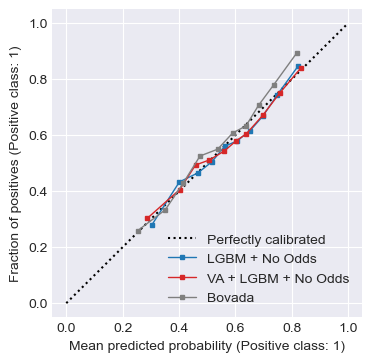

In [64]:
from sklearn.calibration import CalibrationDisplay

plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(4, 4))
names = ["LightGBM (No Odds)", "Venn-Abers LightGBM (No Odds)", "Bovada Sportsbook"]
disp_names = ["LGBM + No Odds", "VA + LGBM + No Odds", "Bovada"]
cmap = plt.get_cmap("tab10")
colors = [cmap(0), cmap(3), cmap(7)]
for i, name in enumerate(names):
    disp = CalibrationDisplay.from_predictions(
        subset["red_win"],
        subset[name],
        name=disp_names[i],
        n_bins=10,
        strategy="quantile",
        ax=ax,
        color=colors[i],
        markersize=3,    # Smaller points
        linewidth=1
    )
plt.show()